
--- Total Revenue and Units Sold per Book ---
                                  title  total_units_sold  total_revenue
0  The Hitchhiker's Guide to the Galaxy                 4           40.0
1                   Pride and Prejudice                 5           40.0
2                                  1984                 3           36.0
3                      The Great Gatsby                 4           28.0
4                 To Kill a Mockingbird                 1            9.5


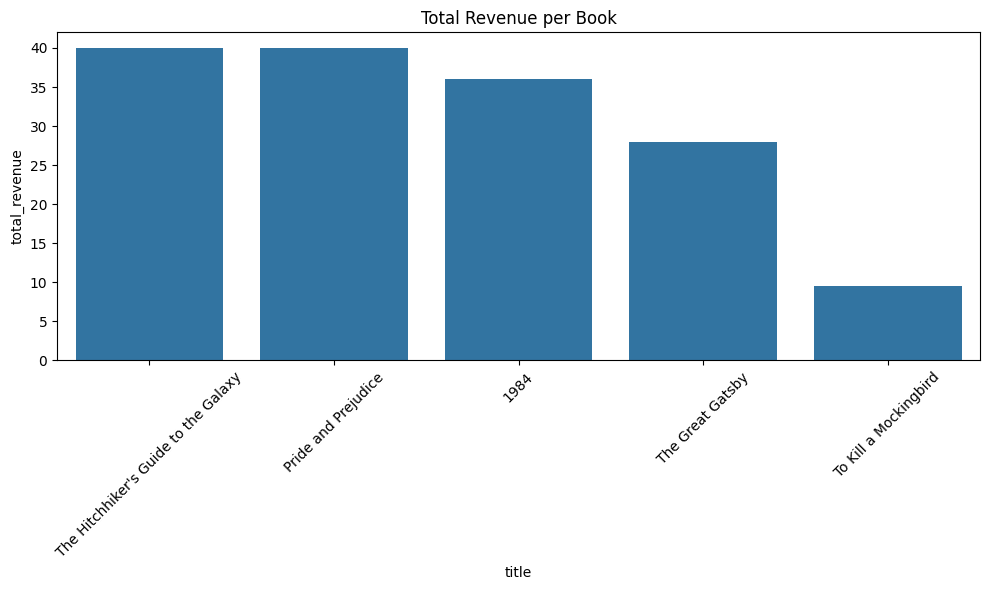


--- Low-stock Books ---
                   title  stock
0  To Kill a Mockingbird     10


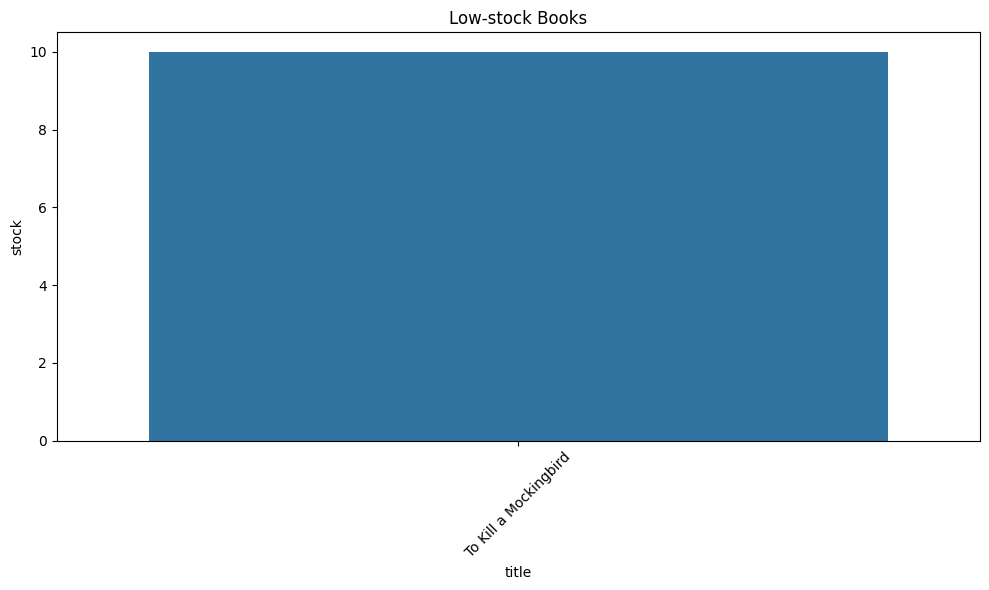


--- Customer RFM Analysis ---
   customer_id     name  last_order  frequency  monetary  recency_days
0            1    Alice  2024-07-01          4      47.0           0.0
1            2      Bob  2024-05-20          2      31.0          42.0
2            3  Charlie  2023-05-05          2      34.0         423.0
3            4    David  2024-06-01          2      24.0          30.0
4            5      Eve  2024-06-15          2      17.5          16.0


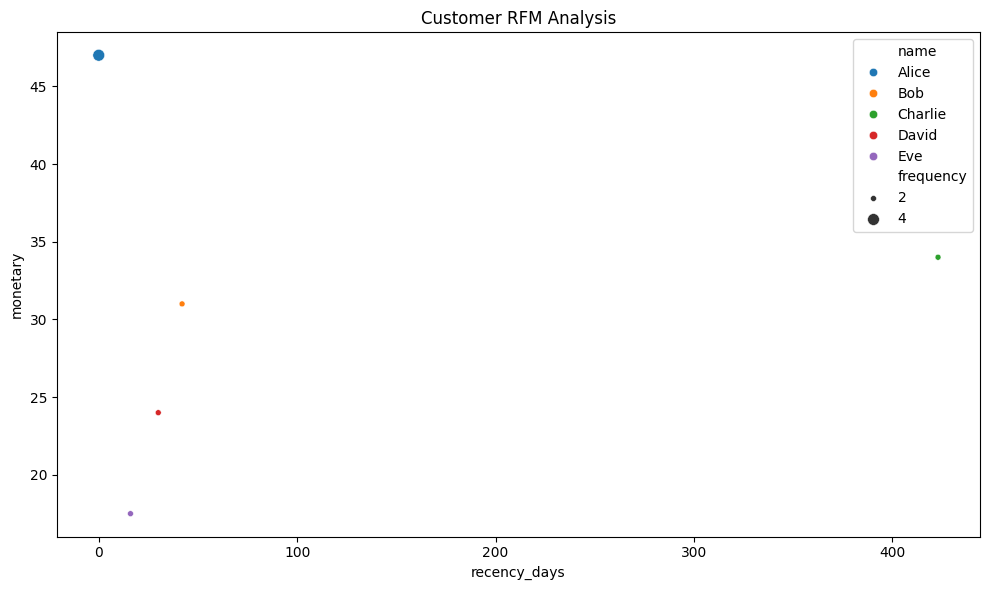


--- Customer ROI Analysis ---
   customer_id     name  spend_amount  total_revenue  profit
0            1    Alice          50.0           47.0    -3.0
1            2      Bob          30.0           31.0     1.0
2            3  Charlie          20.0           34.0    14.0
3            4    David          10.0           24.0    14.0
4            5      Eve          15.0           17.5     2.5


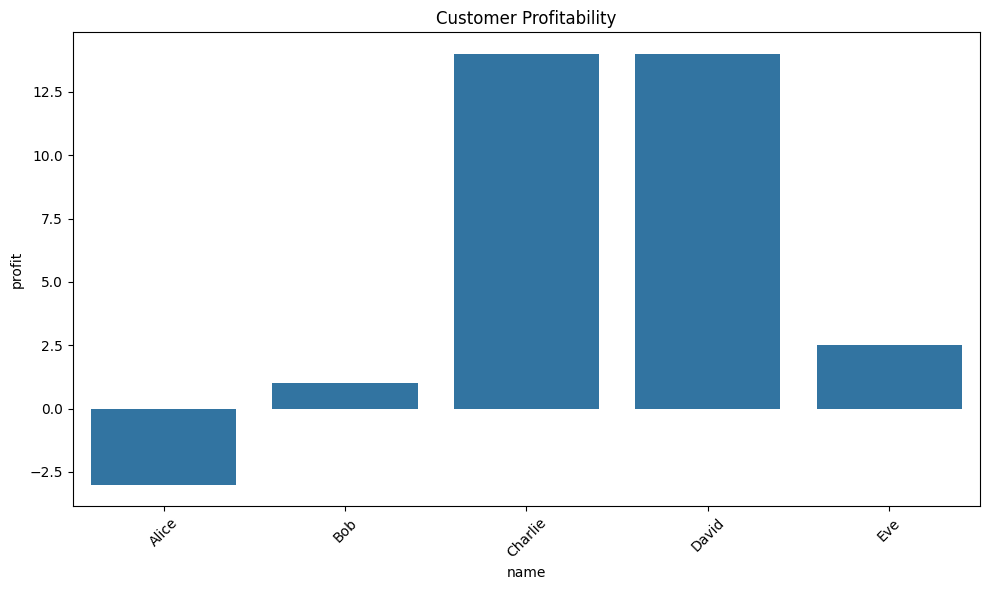


--- Monthly Revenue Trend ---
     month  total_revenue
0  2023-01           20.0
1  2023-02           24.0
2  2023-03           12.0
3  2023-04           10.0
4  2023-05           24.0
5  2024-01           10.0
6  2024-02            8.0
7  2024-05           15.0
8  2024-06           23.5
9  2024-07            7.0


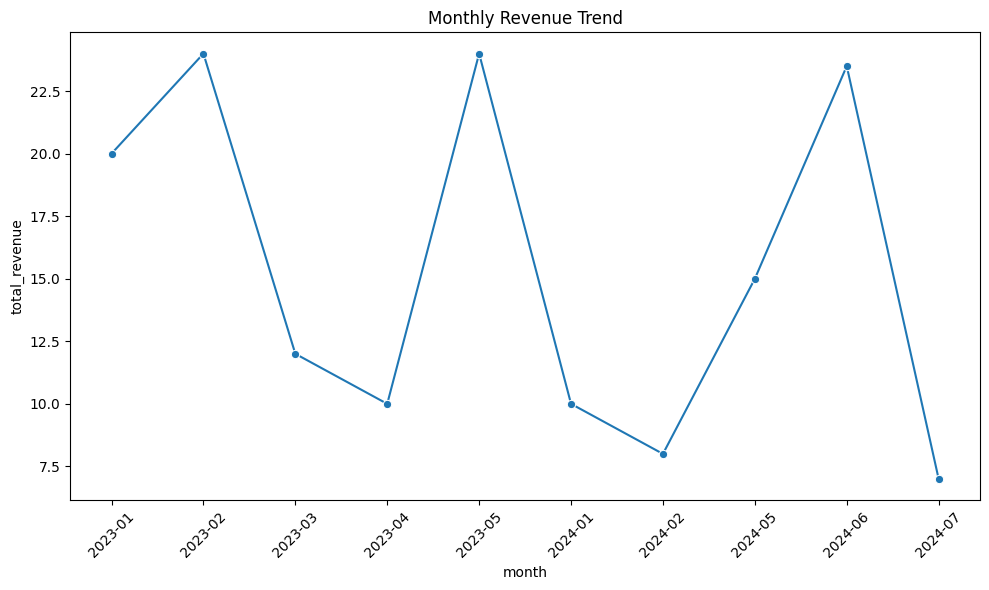


--- Repeat Customers ---
   customer_id     name  total_orders
0            1    Alice             4
1            2      Bob             2
2            3  Charlie             2
3            4    David             2
4            5      Eve             2


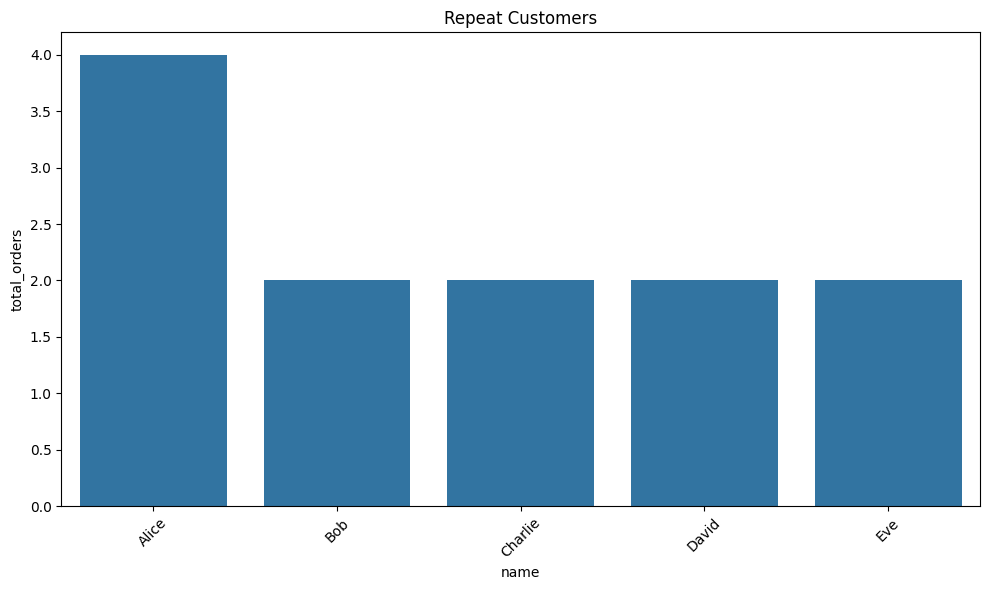


--- Average Order Value ---
   avg_order_value
0            12.79


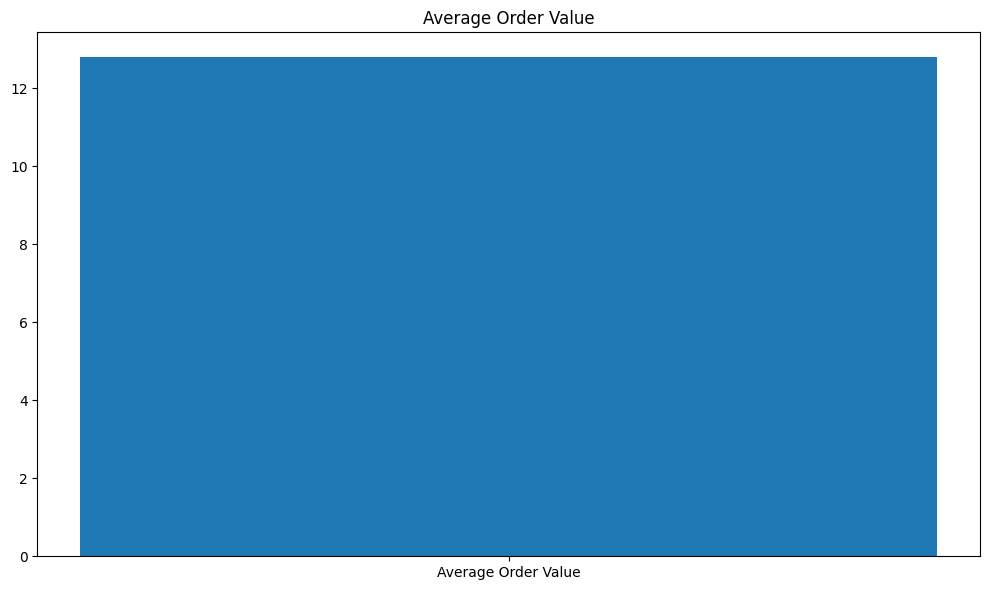


--- Market Basket Analysis ---
   book_1  book_2  times_bought_together
0       1       3                      2
1       1       5                      2
2       2       5                      2
3       1       2                      1
4       2       3                      1
5       2       4                      1
6       3       5                      1


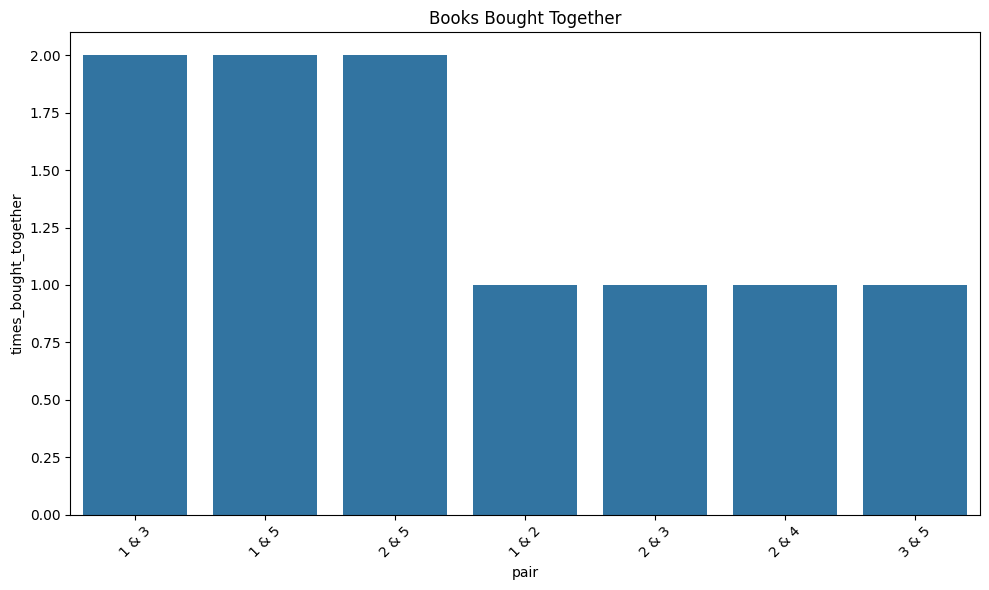


--- Churn Analysis ---
   customer_id     name last_purchase  days_since_last_purchase
0            2      Bob    2024-05-20                     407.0
1            3  Charlie    2023-05-05                     788.0
2            4    David    2024-06-01                     395.0
3            5      Eve    2024-06-15                     381.0


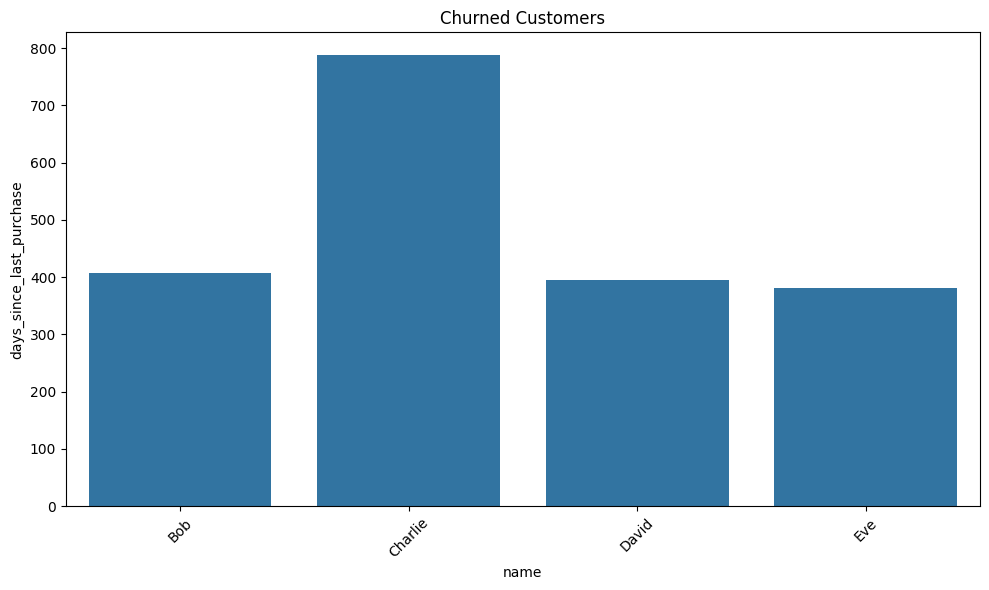

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect("bookstore_analytics.db")

# Define all analytics queries
queries = {
    "Total Revenue and Units Sold per Book": """
        SELECT
            b.title,
            SUM(o.quantity) AS total_units_sold,
            SUM(o.quantity * b.price) AS total_revenue
        FROM Orders o
        JOIN Books b ON o.book_id = b.book_id
        GROUP BY b.title
        ORDER BY total_revenue DESC;
    """,
    "Low-stock Books": """
        SELECT
            title,
            stock
        FROM Books
        WHERE stock < 15;
    """,
    "Customer RFM Analysis": """
        WITH customer_metrics AS (
            SELECT
                c.customer_id,
                c.name,
                MAX(order_date) AS last_order,
                COUNT(o.order_id) AS frequency,
                SUM(o.quantity * b.price) AS monetary
            FROM Customers c
            JOIN Orders o ON c.customer_id = o.customer_id
            JOIN Books b ON o.book_id = b.book_id
            GROUP BY c.customer_id
        )
        SELECT *,
               julianday('2024-07-01') - julianday(last_order) AS recency_days
        FROM customer_metrics;
    """,
    "Customer ROI Analysis": """
        WITH customer_spend AS (
            SELECT
                o.customer_id,
                SUM(o.quantity * b.price) AS total_revenue
            FROM Orders o
            JOIN Books b ON o.book_id = b.book_id
            GROUP BY o.customer_id
        )
        SELECT
            c.customer_id,
            c.name,
            ms.spend_amount,
            cs.total_revenue,
            (cs.total_revenue - ms.spend_amount) AS profit
        FROM Customers c
        JOIN MarketingSpend ms ON c.customer_id = ms.customer_id
        JOIN customer_spend cs ON c.customer_id = cs.customer_id;
    """,
    "Monthly Revenue Trend": """
        SELECT
            STRFTIME('%Y-%m', order_date) AS month,
            SUM(quantity * b.price) AS total_revenue
        FROM Orders o
        JOIN Books b ON o.book_id = b.book_id
        GROUP BY month
        ORDER BY month;
    """,
    "Repeat Customers": """
        SELECT
            c.customer_id,
            c.name,
            COUNT(DISTINCT o.order_id) AS total_orders
        FROM Customers c
        JOIN Orders o ON c.customer_id = o.customer_id
        GROUP BY c.customer_id
        HAVING total_orders > 1;
    """,
    "Average Order Value": """
        SELECT
            ROUND(SUM(quantity * b.price) * 1.0 / COUNT(DISTINCT o.order_id), 2) AS avg_order_value
        FROM Orders o
        JOIN Books b ON o.book_id = b.book_id;
    """,
    "Market Basket Analysis": """
        SELECT
            o1.book_id AS book_1,
            o2.book_id AS book_2,
            COUNT(*) AS times_bought_together
        FROM Orders o1
        JOIN Orders o2
          ON o1.customer_id = o2.customer_id AND o1.order_id != o2.order_id
        WHERE o1.book_id < o2.book_id
        GROUP BY book_1, book_2
        ORDER BY times_bought_together DESC
        LIMIT 10;
    """,
    "Churn Analysis": """
        SELECT
            c.customer_id,
            c.name,
            MAX(o.order_date) AS last_purchase,
            ROUND(julianday('2025-07-01') - julianday(MAX(o.order_date))) AS days_since_last_purchase
        FROM Customers c
        JOIN Orders o ON c.customer_id = o.customer_id
        GROUP BY c.customer_id
        HAVING days_since_last_purchase > 365;
    """
}

# Run each query and visualize results
for title, query in queries.items():
    df = pd.read_sql_query(query, conn)
    print(f"\n--- {title} ---")
    print(df)

    # Visualization logic
    plt.figure(figsize=(10, 6))
    if title == "Total Revenue and Units Sold per Book":
        sns.barplot(x="title", y="total_revenue", data=df)
        plt.title("Total Revenue per Book")
        plt.xticks(rotation=45)
    elif title == "Low-stock Books":
        sns.barplot(x="title", y="stock", data=df)
        plt.title("Low-stock Books")
        plt.xticks(rotation=45)
    elif title == "Customer RFM Analysis":
        sns.scatterplot(x="recency_days", y="monetary", size="frequency", hue="name", data=df)
        plt.title("Customer RFM Analysis")
    elif title == "Customer ROI Analysis":
        sns.barplot(x="name", y="profit", data=df)
        plt.title("Customer Profitability")
        plt.xticks(rotation=45)
    elif title == "Monthly Revenue Trend":
        sns.lineplot(x="month", y="total_revenue", data=df, marker="o")
        plt.title("Monthly Revenue Trend")
        plt.xticks(rotation=45)
    elif title == "Repeat Customers":
        sns.barplot(x="name", y="total_orders", data=df)
        plt.title("Repeat Customers")
        plt.xticks(rotation=45)
    elif title == "Average Order Value":
        plt.bar(["Average Order Value"], df["avg_order_value"])
        plt.title("Average Order Value")
    elif title == "Market Basket Analysis":
        df["pair"] = df["book_1"].astype(str) + " & " + df["book_2"].astype(str)
        sns.barplot(x="pair", y="times_bought_together", data=df)
        plt.title("Books Bought Together")
        plt.xticks(rotation=45)
    elif title == "Churn Analysis":
        sns.barplot(x="name", y="days_since_last_purchase", data=df)
        plt.title("Churned Customers")
        plt.xticks(rotation=45)
    else:
        plt.close()
        continue

    plt.tight_layout()
    plt.show()

# Close the database connection
conn.close()

In [6]:
# Create tables and insert sample data
conn = sqlite3.connect("bookstore_analytics.db")
cursor = conn.cursor()

# Create Customers table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Customers (
        customer_id INTEGER PRIMARY KEY,
        name TEXT NOT NULL
    )
""")

# Create Books table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Books (
        book_id INTEGER PRIMARY KEY,
        title TEXT NOT NULL,
        price REAL NOT NULL,
        stock INTEGER NOT NULL
    )
""")

# Create Orders table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS Orders (
        order_id INTEGER PRIMARY KEY,
        customer_id INTEGER,
        book_id INTEGER,
        quantity INTEGER NOT NULL,
        order_date TEXT NOT NULL,
        FOREIGN KEY (customer_id) REFERENCES Customers(customer_id),
        FOREIGN KEY (book_id) REFERENCES Books(book_id)
    )
""")

# Create MarketingSpend table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS MarketingSpend (
        customer_id INTEGER PRIMARY KEY,
        spend_amount REAL NOT NULL,
        FOREIGN KEY (customer_id) REFERENCES Customers(customer_id)
    )
""")

# Insert sample data into Customers
customer_data = [
    (1, 'Alice'),
    (2, 'Bob'),
    (3, 'Charlie'),
    (4, 'David'),
    (5, 'Eve')
]
cursor.executemany("INSERT OR IGNORE INTO Customers VALUES (?, ?)", customer_data)

# Insert sample data into Books
book_data = [
    (1, 'The Hitchhiker\'s Guide to the Galaxy', 10.00, 50),
    (2, 'Pride and Prejudice', 8.00, 30),
    (3, '1984', 12.00, 20),
    (4, 'To Kill a Mockingbird', 9.50, 10),
    (5, 'The Great Gatsby', 7.00, 15)
]
cursor.executemany("INSERT OR IGNORE INTO Books VALUES (?, ?, ?, ?)", book_data)

# Insert sample data into Orders
order_data = [
    (1, 1, 1, 2, '2023-01-15'),
    (2, 1, 3, 1, '2023-03-20'),
    (3, 2, 2, 3, '2023-02-10'),
    (4, 3, 1, 1, '2023-04-01'),
    (5, 4, 5, 2, '2024-06-01'),
    (6, 5, 4, 1, '2024-06-15'),
    (7, 1, 2, 1, '2024-05-10'),
    (8, 2, 5, 1, '2024-05-20'),
    (9, 3, 3, 2, '2023-05-05'),
    (10, 4, 1, 1, '2024-01-01'),
    (11, 5, 2, 1, '2024-02-01'),
    (12, 1, 5, 1, '2024-07-01')

]
cursor.executemany("INSERT OR IGNORE INTO Orders VALUES (?, ?, ?, ?, ?)", order_data)

# Insert sample data into MarketingSpend
marketing_data = [
    (1, 50.00),
    (2, 30.00),
    (3, 20.00),
    (4, 10.00),
    (5, 15.00)
]
cursor.executemany("INSERT OR IGNORE INTO MarketingSpend VALUES (?, ?)", marketing_data)


conn.commit()
conn.close()